In [2]:
import os 
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset, ClassLabel
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score


In [3]:
df = pd.read_csv('Training_data_preprocessed.csv')
df.head()

,Text,Category,EmailType,clean_text,tokens
0,"Hi *******, Your payment to Uber India was App...",category_3,email_type_93,hi payment uber india approved paid amount ube...,"['hi', 'payment', 'uber', 'india', 'approved',..."
1,Your Zomato Online Ordering receipt Refund Pro...,category_3,email_type_84,zomato online ordering receipt refund processe...,"['zomato', 'online', 'ordering', 'receipt', 'r..."
2,Electricity Bill Payment Successful ‚Çπ 979 Fo...,category_3,email_type_3,electricity bill payment successful ‚çπ 979 ce...,"['electricity', 'bill', 'payment', 'successful..."
3,Payment requested by FINCFRIENDS PVT. LTD. Rec...,category_3,email_type_92,payment requested fincfriends pvt ltd receipt ...,"['payment', 'requested', 'fincfriends', 'pvt',..."
4,Greetings from Swiggy Your order was delivered...,category_3,email_type_86,greeting swiggy order delivered 29 minute rate...,"['greeting', 'swiggy', 'order', 'delivered', '..."


In [4]:
# Convert categorical labels to numerical labels
category_labels = ClassLabel(names=list(df['Category'].unique()))
type_labels = ClassLabel(names=list(df['EmailType'].unique()))

df['Category'] = df['Category'].map(lambda x: category_labels.str2int(x))
df['EmailType'] = df['EmailType'].map(lambda x: type_labels.str2int(x))

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [5]:
from gensim.models import Word2Vec

data = df

# Encode labels
category_encoder = LabelEncoder()
emailtype_encoder = LabelEncoder()

data['Category'] = category_encoder.fit_transform(data['Category'])
data['EmailType'] = emailtype_encoder.fit_transform(data['EmailType'])

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_tfidf = tfidf.fit_transform(data['clean_text']).toarray()
y_category = data['Category'].values
y_emailtype = data['EmailType'].values

# CBOW

# cbow_model = Word2Vec(data['clean_text'], vector_size=1000, window=5, min_count=1, workers=4)

# # # Create feature vectors for each text sample
# X = np.array([np.mean([cbow_model.wv[word] for word in sentence if word in cbow_model.wv] or [np.zeros(cbow_model.vector_size)], axis=0) for sentence in data['clean_text']])

# Dataset class
class TextDataset(Dataset):
    def __init__(self, X, y1, y2):
        self.X = X
        self.y1 = y1
        self.y2 = y2

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y1[idx], dtype=torch.long), torch.tensor(self.y2[idx], dtype=torch.long)

# Model class
class MultiTaskModel(nn.Module):
    def __init__(self, input_dim, num_classes_category, num_classes_emailtype):
        super(MultiTaskModel, self).__init__()
        self.shared_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.category_head = nn.Linear(64, num_classes_category)
        self.emailtype_head = nn.Linear(64, num_classes_emailtype)

    def forward(self, x):
        shared_output = self.shared_layer(x)
        category_output = self.category_head(shared_output)
        emailtype_output = self.emailtype_head(shared_output)
        return category_output, emailtype_output

def get_optimizer_and_criterion(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion_category = nn.CrossEntropyLoss()
    criterion_emailtype = nn.CrossEntropyLoss()
    return optimizer, criterion_category, criterion_emailtype

def train_model(model, train_loader, optimizer, criterion_category, criterion_emailtype, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch_category, y_batch_emailtype in train_loader:
        X_batch, y_batch_category, y_batch_emailtype = X_batch.to(device), y_batch_category.to(device), y_batch_emailtype.to(device)
        
        optimizer.zero_grad()
        output_category, output_emailtype = model(X_batch)
        
        loss_category = criterion_category(output_category, y_batch_category)
        loss_emailtype = criterion_emailtype(output_emailtype, y_batch_emailtype)
        loss = loss_category + loss_emailtype
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, data_loader, device):
    model.eval()
    correct_category = 0
    total_category = 0
    correct_emailtype = 0
    total_emailtype = 0
    
    y_true_category = []
    y_pred_category = []
    y_true_emailtype = []
    y_pred_emailtype = []
    
    with torch.no_grad():
        for X_batch, y_batch_category, y_batch_emailtype in data_loader:
            X_batch, y_batch_category, y_batch_emailtype = X_batch.to(device), y_batch_category.to(device), y_batch_emailtype.to(device)
            
            output_category, output_emailtype = model(X_batch)
            
            _, predicted_category = torch.max(output_category, 1)
            _, predicted_emailtype = torch.max(output_emailtype, 1)
            
            y_true_category.extend(y_batch_category.cpu().numpy())
            y_pred_category.extend(predicted_category.cpu().numpy())
            y_true_emailtype.extend(y_batch_emailtype.cpu().numpy())
            y_pred_emailtype.extend(predicted_emailtype.cpu().numpy())
            
            total_category += y_batch_category.size(0)
            correct_category += (predicted_category == y_batch_category).sum().item()
            
            total_emailtype += y_batch_emailtype.size(0)
            correct_emailtype += (predicted_emailtype == y_batch_emailtype).sum().item()
    
    category_accuracy = correct_category / total_category
    emailtype_accuracy = correct_emailtype / total_emailtype
    
    category_precision = precision_score(y_true_category, y_pred_category, average='weighted')
    category_recall = recall_score(y_true_category, y_pred_category, average='weighted')
    category_f1 = f1_score(y_true_category, y_pred_category, average='weighted')
    
    emailtype_precision = precision_score(y_true_emailtype, y_pred_emailtype, average='weighted')
    emailtype_recall = recall_score(y_true_emailtype, y_pred_emailtype, average='weighted')
    emailtype_f1 = f1_score(y_true_emailtype, y_pred_emailtype, average='weighted')
    
    return {
        "category_accuracy": category_accuracy,
        "category_precision": category_precision,
        "category_recall": category_recall,
        "category_f1": category_f1,
        "emailtype_accuracy": emailtype_accuracy,
        "emailtype_precision": emailtype_precision,
        "emailtype_recall": emailtype_recall,
        "emailtype_f1": emailtype_f1
    }




In [86]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


category_class_weights=compute_class_weight(class_weight = 'balanced',classes = np.unique(df['Category']),y = list(df['Category']))
category_class_weights=torch.tensor(category_class_weights,dtype=torch.float)

emailtype_class_weights=compute_class_weight(class_weight = 'balanced',classes=np.unique(df['EmailType']),y=list(df['EmailType']) )
emailtype_class_weights=torch.tensor(emailtype_class_weights,dtype=torch.float)


In [6]:
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

category_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}
emailtype_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

train_category_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}
train_emailtype_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

def update_metrics(metrics, category_metrics, emailtype_metrics):
    category_metrics["accuracy"].append(metrics["category_accuracy"])
    category_metrics["precision"].append(metrics["category_precision"])
    category_metrics["recall"].append(metrics["category_recall"])
    category_metrics["f1"].append(metrics["category_f1"])
    
    emailtype_metrics["accuracy"].append(metrics["emailtype_accuracy"])
    emailtype_metrics["precision"].append(metrics["emailtype_precision"])
    emailtype_metrics["recall"].append(metrics["emailtype_recall"])
    emailtype_metrics["f1"].append(metrics["emailtype_f1"])
    return category_metrics, emailtype_metrics
# Uncomment if CBOW
# X_tfidf = X
for fold, (train_idx, val_idx) in enumerate(kf.split(X_tfidf)):
    X_train, X_val = X_tfidf[train_idx], X_tfidf[val_idx]
    y_train_category, y_val_category = y_category[train_idx], y_category[val_idx]
    y_train_emailtype, y_val_emailtype = y_emailtype[train_idx], y_emailtype[val_idx]
    
    train_dataset = TextDataset(X_train, y_train_category, y_train_emailtype)
    val_dataset = TextDataset(X_val, y_val_category, y_val_emailtype)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    model = MultiTaskModel(input_dim=X_tfidf.shape[1], num_classes_category=3, num_classes_emailtype=143).to(device)
    optimizer, criterion_category, criterion_emailtype = get_optimizer_and_criterion(model)
    
    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion_category, criterion_emailtype, device)
        print(f"Fold {fold + 1}, Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}")
    
    metrics = evaluate_model(model, val_loader, device)
    train_metrics = evaluate_model(model, train_loader, device)
    category_metrics, emailtype_metrics = update_metrics(metrics, category_metrics, emailtype_metrics)
    train_category_metrics, train_emailtype_metrics = update_metrics(train_metrics, train_category_metrics, train_emailtype_metrics)
    print(f"Fold {fold + 1}, Category Train Accuracy: {train_metrics['category_accuracy']:.2f}%, Precision: {train_metrics['category_precision']:.2f}, Recall: {train_metrics['category_recall']:.2f}, F1-Score: {train_metrics['category_f1']:.2f}")
    print(f"Fold {fold + 1}, EmailType Train Accuracy: {train_metrics['emailtype_accuracy']:.2f}%, Precision: {train_metrics['emailtype_precision']:.2f}, Recall: {train_metrics['emailtype_recall']:.2f}, F1-Score: {train_metrics['emailtype_f1']:.2f}")
    print(f"Fold {fold + 1}, Category Accuracy: {metrics['category_accuracy']:.2f}%, Precision: {metrics['category_precision']:.2f}, Recall: {metrics['category_recall']:.2f}, F1-Score: {metrics['category_f1']:.2f}")
    print(f"Fold {fold + 1}, EmailType Accuracy: {metrics['emailtype_accuracy']:.2f}%, Precision: {metrics['emailtype_precision']:.2f}, Recall: {metrics['emailtype_recall']:.2f}, F1-Score: {metrics['emailtype_f1']:.2f}")

print(f"Average Category Accuracy: {np.mean(category_metrics['accuracy']):.2f}%")
print(f"Average Category Precision: {np.mean(category_metrics['precision']):.2f}")
print(f"Average Category Recall: {np.mean(category_metrics['recall']):.2f}")
print(f"Average Category F1-Score: {np.mean(category_metrics['f1']):.2f}")

print(f"Average EmailType Accuracy: {np.mean(emailtype_metrics['accuracy'])}")
print(f"Average EmailType Precision: {np.mean(emailtype_metrics['precision'])}")
print(f"Average EmailType Recall: {np.mean(emailtype_metrics['recall'])}")
print(f"Average EmailType F1-Score: {np.mean(emailtype_metrics['f1'])}")

Fold 1, Epoch [1/10], Loss: 1.6515
Fold 1, Epoch [2/10], Loss: 0.5140
Fold 1, Epoch [3/10], Loss: 0.3377
Fold 1, Epoch [4/10], Loss: 0.2519
Fold 1, Epoch [5/10], Loss: 0.2000
Fold 1, Epoch [6/10], Loss: 0.1608
Fold 1, Epoch [7/10], Loss: 0.1370
Fold 1, Epoch [8/10], Loss: 0.1150
Fold 1, Epoch [9/10], Loss: 0.1010
Fold 1, Epoch [10/10], Loss: 0.0879


/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 

Fold 1, Category Train Accuracy: 1.00%, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Fold 1, EmailType Train Accuracy: 0.98%, Precision: 0.98, Recall: 0.98, F1-Score: 0.98
Fold 1, Category Accuracy: 0.99%, Precision: 0.99, Recall: 0.99, F1-Score: 0.99
Fold 1, EmailType Accuracy: 0.95%, Precision: 0.95, Recall: 0.95, F1-Score: 0.95
Fold 2, Epoch [1/10], Loss: 1.6088
Fold 2, Epoch [2/10], Loss: 0.5175
Fold 2, Epoch [3/10], Loss: 0.3359
Fold 2, Epoch [4/10], Loss: 0.2499
Fold 2, Epoch [5/10], Loss: 0.1959
Fold 2, Epoch [6/10], Loss: 0.1604
Fold 2, Epoch [7/10], Loss: 0.1343
Fold 2, Epoch [8/10], Loss: 0.1118
Fold 2, Epoch [9/10], Loss: 0.0967
Fold 2, Epoch [10/10], Loss: 0.0853


/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 

Fold 2, Category Train Accuracy: 1.00%, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Fold 2, EmailType Train Accuracy: 0.98%, Precision: 0.98, Recall: 0.98, F1-Score: 0.98
Fold 2, Category Accuracy: 0.99%, Precision: 0.99, Recall: 0.99, F1-Score: 0.99
Fold 2, EmailType Accuracy: 0.95%, Precision: 0.95, Recall: 0.95, F1-Score: 0.95
Fold 3, Epoch [1/10], Loss: 1.5343
Fold 3, Epoch [2/10], Loss: 0.4888
Fold 3, Epoch [3/10], Loss: 0.3160
Fold 3, Epoch [4/10], Loss: 0.2305
Fold 3, Epoch [5/10], Loss: 0.1822
Fold 3, Epoch [6/10], Loss: 0.1486
Fold 3, Epoch [7/10], Loss: 0.1198
Fold 3, Epoch [8/10], Loss: 0.1041
Fold 3, Epoch [9/10], Loss: 0.0873
Fold 3, Epoch [10/10], Loss: 0.0791


/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 

Fold 3, Category Train Accuracy: 1.00%, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Fold 3, EmailType Train Accuracy: 0.98%, Precision: 0.98, Recall: 0.98, F1-Score: 0.98
Fold 3, Category Accuracy: 0.98%, Precision: 0.98, Recall: 0.98, F1-Score: 0.98
Fold 3, EmailType Accuracy: 0.95%, Precision: 0.95, Recall: 0.95, F1-Score: 0.95
Fold 4, Epoch [1/10], Loss: 1.6058
Fold 4, Epoch [2/10], Loss: 0.5043
Fold 4, Epoch [3/10], Loss: 0.3228
Fold 4, Epoch [4/10], Loss: 0.2430
Fold 4, Epoch [5/10], Loss: 0.1925
Fold 4, Epoch [6/10], Loss: 0.1564
Fold 4, Epoch [7/10], Loss: 0.1309
Fold 4, Epoch [8/10], Loss: 0.1113
Fold 4, Epoch [9/10], Loss: 0.0934
Fold 4, Epoch [10/10], Loss: 0.0832


/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 

Fold 4, Category Train Accuracy: 1.00%, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Fold 4, EmailType Train Accuracy: 0.98%, Precision: 0.98, Recall: 0.98, F1-Score: 0.98
Fold 4, Category Accuracy: 0.99%, Precision: 0.99, Recall: 0.99, F1-Score: 0.99
Fold 4, EmailType Accuracy: 0.96%, Precision: 0.96, Recall: 0.96, F1-Score: 0.96
Fold 5, Epoch [1/10], Loss: 1.6038
Fold 5, Epoch [2/10], Loss: 0.5028
Fold 5, Epoch [3/10], Loss: 0.3226
Fold 5, Epoch [4/10], Loss: 0.2392
Fold 5, Epoch [5/10], Loss: 0.1890
Fold 5, Epoch [6/10], Loss: 0.1552
Fold 5, Epoch [7/10], Loss: 0.1291
Fold 5, Epoch [8/10], Loss: 0.1098
Fold 5, Epoch [9/10], Loss: 0.0937
Fold 5, Epoch [10/10], Loss: 0.0817


/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 

Fold 5, Category Train Accuracy: 1.00%, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Fold 5, EmailType Train Accuracy: 0.98%, Precision: 0.98, Recall: 0.98, F1-Score: 0.98
Fold 5, Category Accuracy: 0.99%, Precision: 0.99, Recall: 0.99, F1-Score: 0.99
Fold 5, EmailType Accuracy: 0.96%, Precision: 0.96, Recall: 0.96, F1-Score: 0.96
Average Category Accuracy: 0.99%
Average Category Precision: 0.99
Average Category Recall: 0.99
Average Category F1-Score: 0.99
Average EmailType Accuracy: 0.9552933671262938
Average EmailType Precision: 0.9545865336568623
Average EmailType Recall: 0.9552933671262938
Average EmailType F1-Score: 0.9536854079969185


/Users/lavishmaheswari/Documents/envs/cie-nlp-service/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


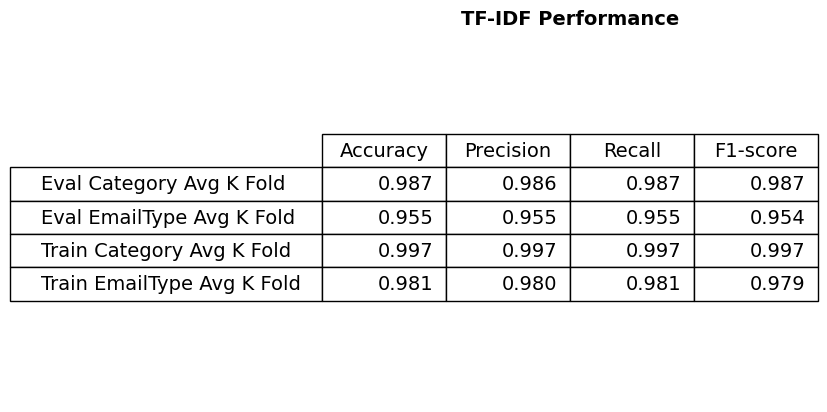

In [18]:
import matplotlib.pyplot as plt

fig, ax =plt.subplots(1,1)



column_labels=['Accuracy', 'Precision', 'Recall', 'F1-score']


total_values = []
for metric in [category_metrics, emailtype_metrics, train_category_metrics, train_emailtype_metrics]:
    temp = []
    for cat, values in metric.items():
        temp.append(f"{np.mean(values):.3f}")
    total_values.append(temp)
    
#creating a 2-dimensional dataframe out of the given data
df=pd.DataFrame(data,columns=column_labels)

ax.axis('tight') #turns off the axis lines and labels
ax.axis('off') #changes x and y axis limits such that all data is shown

#plotting data
table = ax.table(cellText=total_values,
        colLabels=df.columns,
        rowLabels=["Eval Category Avg K Fold", "Eval EmailType Avg K Fold","Train Category Avg K Fold", "Train EmailType Avg K Fold"],
        loc="center")
table.set_fontsize(14)
table.scale(1,2)
plt.title('TF-IDF Performance', fontsize=14, fontweight='bold')
plt.show()

In [17]:


category_metrics

{'accuracy': [0.9883809815012995,
  0.9859348723436784,
  0.9831804281345565,
  0.9885321100917431,
  0.9882262996941896],
 'precision': [0.9878885041458209,
  0.9856213681811604,
  0.982738934368415,
  0.9877784227676113,
  0.9875663884981821],
 'recall': [0.9883809815012995,
  0.9859348723436784,
  0.9831804281345565,
  0.9885321100917431,
  0.9882262996941896],
 'f1': [0.9881318697390198,
  0.9857656908748446,
  0.9829231506632395,
  0.9881551157954128,
  0.9878895948584212]}

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Define the input layer
input_layer = Input(shape=(X_train.shape[1],))

# Shared layers
shared_dense = Dense(128, activation='relu')(input_layer)

# Output layers for each task
category_output = Dense(1, activation='sigmoid', name='category_output')(shared_dense)
emailtype_output = Dense(1, activation='sigmoid', name='emailtype_output')(shared_dense)

# Build the model
model = Model(inputs=input_layer, outputs=[category_output, emailtype_output])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'category_output': 'categorical_crossentropy', 'emailtype_output': 'categorical_crossentropy'},
              metrics={'category_output': 'accuracy', 'emailtype_output': 'accuracy'})

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    128,128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_output     │ (None, 1)         │        129 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emailtype_output    │ (None, 1)         │        129 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 128,386 (501.51 KB)

 Trainable params: 128,386 (501.51 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(X_train, 
                    {'category_output': y_train_category, 'emailtype_output': y_train_emailtype},
                    validation_data=(X_test, {'category_output': y_test_category, 'emailtype_output': y_test_emailtype}),
                    epochs=4,
                    batch_size=8)


Epoch 1/4


2024-05-18 11:53:55.664835: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-18 11:53:55.665377: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000204999 Hz
2024-05-18 11:53:56.618270: E tensorflow/stream_executor/cuda/cuda_blas.cc:197] failed to set new cublas math mode: CUBLAS_STATUS_INVALID_VALUE


InternalError:  Blas xGEMM launch failed : a.shape=[1,8,1000], b.shape=[1,1000,128], m=8, n=128, k=1000
	 [[node model/dense/MatMul (defined at var/tmp/ipykernel_22287/3358670577.py:6) ]] [Op:__inference_train_function_988]

Function call stack:
train_function
